In [34]:
import numpy as np
edges = np.loadtxt('Gowalla_edges.txt',dtype=int)
print(edges.shape) #1900654 amount of pair examples


(1900654, 2)


In [35]:
#Just for comparison
#Unique users amount
nodes_dat=196591 
#Connections between users
edges_dat=950327
#Total num of check ins
checkins_dat=6442890


In [61]:
#Data preprocessing building message graph==similarity
#Unique users array
users=np.unique(edges)
print(users)
#Unique users amount
n=len(users)
print(n)

# S, A, R matrices (n,n) but dimension is too large even for sparse matrix, thats why need to concatenate parts 
#or use np.array
connections=[]
similarity_list=[]

for i in range (0,len(edges)):
    #users connection from ->to
    #pair=(edges[i][0],edges[i][1])
    connections.append((edges[i][0],edges[i][1]))
    #each connection markes as 1 in simularity array 
    similarity_list.append(1)
    
for user in range(0,n):
    connections.append((user,user))# self-connection add as pair
#transform to numpy array for memory
similarity_array = np.array(similarity_list) #this is without self-simularity
print(np.shape(similarity_array)) #1900654 all pairs were added 
print(np.shape(connections))#(2097245, 2) =1900654(pairs)+196591(self)

[     0      1      2 ... 196588 196589 196590]
196591
(1900654,)
(2097245, 2)


In [78]:
def update_responsibility(S,A,R_old,connections,damping):
    #sum in formula
    V = S + A#(2097245
    #need to store 2 max sum arrays because we need to avoid self value being max value
    #initialize as -inf
    first_max=np.repeat(-np.inf, n)#np.full(-np.inf,n)#196591 as rows
    second_max=np.repeat(-np.inf, n)
    pair_max=np.repeat(np.inf, n)

    for idx,pair in enumerate(connections):
        #print(pair)
        #connection and V have same dimension and idxes order
        #for pair[0] first user update max and remember 
        if first_max[pair[0]]<V[idx]:
            second_max[pair[0]]=first_max[pair[0]]
            first_max[pair[0]]=V[idx]
            #store number of second user with which first one has max V
            pair_max[pair[0]]=pair[1]
        elif second_max[pair[0]]<V[idx]:
            second_max[pair[0]]=V[idx]
    #because we need to substract max from it        
    R=S.copy()   
    for idx,pair in enumerate(connections):
        #if it is self responsibility value then take second_max 
        if pair_max[pair[0]] == pair[1]:
            R[idx]-=second_max[pair[0]]
        else:
            R[idx]-=first_max[pair[0]]
        
    return R_old*damping+(1-damping)*R
    #return R

In [79]:
def update_availability(A,R,connections,damping):
    A_old=A.copy()
    #drop self-resp values
    R_copy = R.copy()
    #max between 0 and responsibility value (if negative make it zero), a(k,k) counted here
    #len(edges) meaning we dont consider self-r values
    for i in range(0,len(edges)):
        #r[r < 0] = 0
        if R_copy[i] < 0:
            R_copy[i] = 0
    positive_r = np.repeat(0, n) #np.full(0,n)
    
    for idx, pair in enumerate(connections):
        positive_r[pair[1]] += R_copy[idx]
    
    for idx, pair in enumerate(connections):
        A[idx] = positive_r[pair[1]] - R_copy[idx]
    #count min
    for i in range(0,len(edges)):
        A[i] = np.min([0, A[i]])
    return A_old*damping+(1-damping)*A
    #return A

In [80]:
def get_exemplars(R,A,connections):
    temp = np.repeat(-np.inf, n)# stores max values for comparison
    exemplars = dict() #store as dictionary with indexes because otherwise indexes is non int values for transitivity
    #sum responsibility and availability 
    value_sum = R+A
    # for each user get exemplar
    for idx, pair in enumerate(connections):
        #find max val
        #if value_sum for this user is bigger than stored max value, then update
        # and add user idx with which this msx value is achieved as exemplar for initial user
        if value_sum[idx] > temp[pair[0]]:
            temp[pair[0]] = value_sum[idx]
            exemplars[pair[0]] = pair[1] #for user_1 store user_2 as exemplar (if value_sum with user_2 is bigger)
    for i in range(5):        
        for exempl_a in exemplars.keys(): 
            exempl_b = exemplars[exempl_a] #exemplar b for user a
            if exemplars[exempl_b] != exempl_b: #if b is not exemplar for b (self-exemplar)
                exempl_с = exemplars[exempl_b] #find exemplar for b, it is c
                exemplars[exempl_a] = exempl_с #update main: put exemplar c as exemplae for a  
    return exemplars

In [81]:
def affinity_propagation(similarity_array_input,connections,num_iterations,self_similarity_param):
    #Initialization 
    #similarity: 1=if there is a connection between users, 0=if there is no connection
    #self_similarity_param=if it is self-connection
    similarity_array=np.append(similarity_array_input,np.repeat(self_similarity_param,n))
    #as zero
    responsibility_array=np.repeat(0, similarity_array.shape[0])#np.zeros(len(similarity_array)) #(2097245,)
    availability_array=np.repeat(0, similarity_array.shape[0]) #np.zeros(len(similarity_array)) #(2097245,)
    #print(np.shape(responsibility_array)) 
    for i in range(0,num_iterations):
        #Step 1
        responsibility_array=update_responsibility(similarity_array,availability_array,responsibility_array,connections,damping=0.9)
        #Step 2
        availability_array=update_availability(availability_array,responsibility_array,connections,damping=0.9)
        print(i)
    #Based on counted values get examplars as max for each cluster    
    exemplars=get_exemplars(responsibility_array,availability_array,connections)
    #???? WHAAAAAAAAt
    #result = transitiv_convolution(exemplars)
    return exemplars

#affinity_propagation(similarity_array,connections,1,-1.5)


In [82]:
res_exemplars = affinity_propagation(similarity_array,connections,10,-1.5)

0
1
2
3
4
5
6
7
8
9


In [83]:
some_set = set()
for i in res_exemplars.values():
    some_set.add(i)
len(some_set)

5877

In [84]:
cluster_size = dict()
for exemplar in my_exemplars.values():
    if exemplar not in cluster_size:
        cluster_size[exemplar] = 1
    else:
        cluster_size[exemplar] += 1

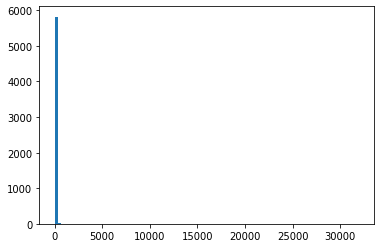

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(cluster_size.values(), bins=100)
plt.show()

In [86]:
max(cluster_size.values())



31970

In [87]:
min(cluster_size.values())

2

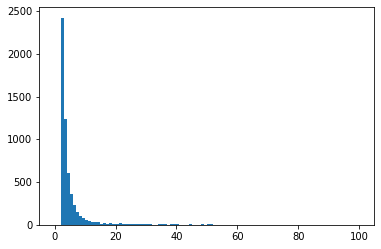

In [88]:
plt.hist(cluster_size.values(), bins=100, range=(0, 100))
plt.show()

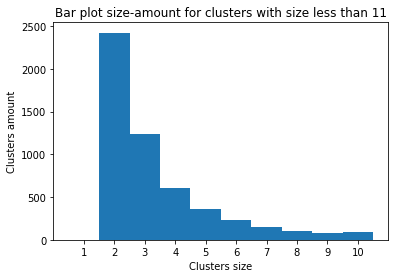

In [89]:
import matplotlib.pyplot as plt
fig = plt.figure()

bins = range(1,12)

plt.hist(cluster_size.values(), bins=bins)  # arguments are passed to np.histogram

plt.xticks(np.arange(1.5,11), labels=bins)

plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Bar plot size-amount for clusters with size less than 11")
plt.tight_layout=True

plt.show()

